## Convolutional Neural Network - Sign Language

In [1]:
%pylab inline
import pandas as pd
from pylab import *
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('training_sets/sign_mnist_train.csv')
df_test  = pd.read_csv('test_sets/sign_mnist_test.csv')

In [3]:
#print(df_train.head())
# 1st column is label
# rest of them are pixels 1-784 = 28*28
Y_train = df_train.iloc[:,0].to_numpy()
X_train = df_train.iloc[:,1:].to_numpy().reshape((-1,28,28))
Y_test  = df_test.iloc[:,0].to_numpy()
X_test  = df_test.iloc[:,1:].to_numpy().reshape((-1,28,28))

X_train = X_train.reshape((-1, 1, 28, 28))  # Shape [batch_size, channels, height, width]
X_test = X_test.reshape((-1, 1, 28, 28))

print(X_train.shape)
print(Y_train.shape)

(27455, 1, 28, 28)
(27455,)


In [4]:
# amount of classes 
print('unique number of labels')
num_classes = np.unique(Y_train) 
print(num_classes)


unique number of labels
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## ConvNet
Images of size 28x28, single channel

this block x3
- convnet -> relu
- convnet -> relu -> pool
 
at the end a fully connected layer


In [17]:
import torch 
import torch.nn as nn
from tqdm import trange, tqdm
import time

class TinyModel(nn.Module):
    def __init__(self, num_classes=25):
        super(TinyModel, self).__init__()
        # block 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8)
        self.act1 = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.act2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 2
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.act3 = nn.ReLU()
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.act4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # adjust based on input size
        self.dropout = nn.Dropout(p=0.5)  # Dropout with probability 0.5
        self.fc2 = nn.Linear(128, num_classes)
   
    def forward(self, x):
        # Block 1
        x = self.cnn1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool1(x)  # After pooling, size is reduced

        # Block 2
        x = self.cnn3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.cnn4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.pool2(x)  # After pooling, size is reduced further

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*4*4)

        # Fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

Loss: 3.18, accuracy: 0.00:   0%|          | 1/600 [00:05<55:38,  5.57s/it]

prediction at epoch 0 is 0.06246514221974345


Loss: 0.17, accuracy: 0.97:  67%|██████▋   | 404/600 [00:29<00:25,  7.83it/s]

prediction at epoch 400 is 0.8326826547685443


Loss: 0.25, accuracy: 0.94: 100%|██████████| 600/600 [00:33<00:00, 18.04it/s]


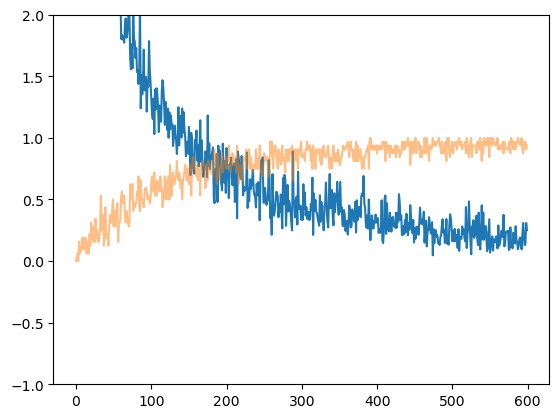

In [26]:
import matplotlib.pyplot as plt

# Training

model = TinyModel()

# set loss function
loss_function = nn.CrossEntropyLoss()

# set optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

losses, accuracies = [], []
BS = 32

# training loop
loop_tam = 600
for i in (t := trange(loop_tam)):
    # select a batch of size BS
    samp = np.random.randint(0,X_train.shape[0], size = (BS))
    X = torch.tensor(X_train[samp]).float()  # No need to reshape to 28*28, keep it as 28x28 with channel
    Y = torch.tensor(Y_train[samp]).long()
    # set all gradient contribution to zero
    optim.zero_grad()

    # perform forward pass
    out = model(X)

    # we want to the see the accuracy of the model as we progress with the iterations
    cat = torch.argmax(out,dim=1)
    accuracy = (cat == Y).float().mean()

    loss = loss_function(out, Y)

    # performa backward pass
    loss.backward()
    optim.step()

    # output some info
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description(f"Loss: {loss:.2f}, accuracy: {accuracy:.2f}")

    if i%400==0:
        # Evaluation
        Y_test_pred = torch.argmax(model(torch.tensor(X_test).float()), dim=1).numpy()
        inter_pred = (Y_test == Y_test_pred).mean()
        print(f'prediction at epoch {i} is {inter_pred}')
        

plt.ylim(-1,2)
plot(losses)
plot(accuracies, alpha = 0.5)


In [27]:
# Evaluation
Y_test_pred = torch.argmax(model(torch.tensor(X_test).float()), dim=1).numpy()
(Y_test == Y_test_pred).mean()

0.8870607919687674